In [1]:
import os, pathlib, torch
from pathlib import Path
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
!nvidia-smi -L || true

# Point to your dataset_split root (contains images/ and labels/)
DATASET_ROOT = Path("/content/dataset_split")  # <-- change if needed
assert (DATASET_ROOT/"images/train").exists() and (DATASET_ROOT/"labels/train").exists(), "dataset_split not found"

# Project output
PROJ = Path("/content/sign_proj"); PROJ.mkdir(parents=True, exist_ok=True)
( PROJ/"results/figs" ).mkdir(parents=True, exist_ok=True)

NAMES = ['yes','no','hello','iloveyou','thankyou']
NAME2IDX = {n:i for i,n in enumerate(NAMES)}
NC = len(NAMES)
print("Classes:", NAMES)

Torch: 2.8.0+cu126 | CUDA: True
GPU 0: Tesla T4 (UUID: GPU-15fd7768-8175-4bcf-519a-a3b9074e2462)
Classes: ['yes', 'no', 'hello', 'iloveyou', 'thankyou']


In [2]:
import shutil, glob

SRC_IMG = DATASET_ROOT/"images"
SRC_LBL = DATASET_ROOT/"labels"
OUT_IMG = PROJ/"data"  # will hold ImageFolder structure
for split in ["train","val","test"]:
    (OUT_IMG/split).mkdir(parents=True, exist_ok=True)
    for cname in NAMES:
        (OUT_IMG/split/cname).mkdir(parents=True, exist_ok=True)

def parse_label_file(lbl_path: Path):
    """
    Returns class index (int) by reading the label file.
    Accepts:
      - '3'           -> int id
      - 'hello'       -> class name
      - '3 0.5 0.5...' (YOLO line) -> first token as int id
    """
    try:
        txt = lbl_path.read_text().strip()
    except Exception:
        return None
    if not txt:
        return None
    line = txt.splitlines()[0].strip()
    token = line.split()[0]
    # Try integer id
    if token.isdigit():
        idx = int(token)
        return idx if 0 <= idx < NC else None
    # Try name
    token_lower = token.lower()
    if token_lower in NAME2IDX:
        return NAME2IDX[token_lower]
    return None

def convert_split(split):
    img_dir = SRC_IMG/split
    lbl_dir = SRC_LBL/split
    out_dir = OUT_IMG/split
    images = sorted([p for p in img_dir.rglob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}])
    moved, skipped = 0, 0
    for img_path in images:
        base = img_path.stem
        lbl_candidates = list(lbl_dir.glob(base+"*"))
        if not lbl_candidates:
            # try matching by extension change
            lbl_candidates = [lbl_dir/(base+".txt")]
        if not lbl_candidates or not lbl_candidates[0].exists():
            skipped += 1
            continue
        idx = parse_label_file(lbl_candidates[0])
        if idx is None or idx >= NC:
            skipped += 1
            continue
        cname = NAMES[idx]
        dst = out_dir/cname/img_path.name
        shutil.copy2(img_path, dst)
        moved += 1
    print(f"[{split}] moved={moved}, skipped(no/malformed label)={skipped}")

for sp in ["train","val","test"]:
    convert_split(sp)

# quick counts
def count_images(root: Path):
    return sum(1 for p in root.rglob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"})
print("Counts:",
      "train=", count_images(OUT_IMG/"train"),
      "val=",   count_images(OUT_IMG/"val"),
      "test=",  count_images(OUT_IMG/"test"))

[train] moved=87, skipped(no/malformed label)=0
[val] moved=25, skipped(no/malformed label)=0
[test] moved=13, skipped(no/malformed label)=0
Counts: train= 87 val= 25 test= 13


In [3]:
# ---- robust sign-aware augmentation (OpenCV, reflect padding) ----
import random, math, numpy as np, shutil, cv2
from pathlib import Path
from tqdm import tqdm

# Reproducibility
SEED = 1337
random.seed(SEED); np.random.seed(SEED)

ALLOW_HFLIP = False
TARGET_TOTAL = 500

TRAIN_SRC = OUT_IMG/"train"
VAL_SRC   = OUT_IMG/"val"
TEST_SRC  = OUT_IMG/"test"

def list_images(d: Path):
    return [p for p in d.rglob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}]
def count_images(d: Path): return len(list_images(d))

def resize_longest_to(img_bgr, max_side=256):
    h, w = img_bgr.shape[:2]; s = max(h, w) or 1
    scale = max_side / float(s)
    nh, nw = max(1,int(round(h*scale))), max(1,int(round(w*scale)))
    return cv2.resize(img_bgr, (nw, nh), interpolation=cv2.INTER_AREA)

def reflect_pad_to(img_bgr, H=256, W=256):
    ih, iw = img_bgr.shape[:2]
    top = max((H-ih)//2, 0); bottom = max(H-ih-top, 0)
    left = max((W-iw)//2, 0); right = max(W-iw-left, 0)
    if top or bottom or left or right:
        img_bgr = cv2.copyMakeBorder(img_bgr, top, bottom, left, right, cv2.BORDER_REFLECT_101)
    return img_bgr

def rand_rotate(img_bgr, deg=10):
    h,w = img_bgr.shape[:2]
    angle = random.uniform(-deg, deg)
    M = cv2.getRotationMatrix2D((w/2,h/2), angle, 1.0)
    return cv2.warpAffine(img_bgr, M, (w,h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

def rand_shift_scale(img_bgr, max_shift=0.05, max_scale=0.05):
    h,w = img_bgr.shape[:2]
    tx = random.uniform(-max_shift, max_shift)*w
    ty = random.uniform(-max_shift, max_shift)*h
    sc = 1.0 + random.uniform(-max_scale, max_scale)
    M = np.array([[sc, 0, tx],[0, sc, ty]], dtype=np.float32)
    return cv2.warpAffine(img_bgr, M, (w,h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

def center_crop_224(img_bgr):
    h,w = img_bgr.shape[:2]
    y = max((h-224)//2, 0); x = max((w-224)//2, 0)
    return img_bgr[y:y+224, x:x+224]

def rand_brightness_contrast(img_bgr, blim=0.10, clim=0.10):
    alpha = 1.0 + random.uniform(-clim, clim)
    beta  = 255 * random.uniform(-blim, blim)
    return cv2.convertScaleAbs(img_bgr, alpha=alpha, beta=beta)

def rand_hflip(img_bgr, p=0.0):
    return cv2.flip(img_bgr, 1) if random.random()<p else img_bgr

def rand_noise_blur(img_bgr):
    if random.random()<0.15:
        sigma = random.uniform(5.0, 12.0)
        noise = np.random.normal(0, sigma, img_bgr.shape).astype(np.float32)
        img_bgr = np.clip(img_bgr.astype(np.float32)+noise, 0, 255).astype(np.uint8)
    if random.random()<0.10:
        img_bgr = cv2.GaussianBlur(img_bgr, (3,3), 0)
    return img_bgr

def rand_coarse_dropout(img_bgr):
    if random.random()<0.12:
        h,w = img_bgr.shape[:2]
        fh = int(h*random.uniform(0.05,0.10))
        fw = int(w*random.uniform(0.05,0.10))
        y  = random.randint(0, max(0,h-fh))
        x  = random.randint(0, max(0,w-fw))
        mean = img_bgr.mean(axis=(0,1)).astype(np.uint8)
        img_bgr[y:y+fh, x:x+fw] = mean
    return img_bgr

def skin_ratio_bgr(img_bgr):
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    lower = np.array([0, 133-25, 77-25], dtype=np.uint8)
    upper = np.array([255, 173+25, 127+25], dtype=np.uint8)
    mask = cv2.inRange(ycrcb, lower, upper)
    return float((mask > 0).mean())

def augment_once_bgr(img_bgr):
    img_bgr = resize_longest_to(img_bgr, 256)
    img_bgr = reflect_pad_to(img_bgr, 256, 256)
    img_bgr = rand_rotate(img_bgr, 10)
    img_bgr = rand_shift_scale(img_bgr, 0.05, 0.05)
    img_bgr = rand_hflip(img_bgr, 0.3 if ALLOW_HFLIP else 0.0)
    img_bgr = rand_brightness_contrast(img_bgr, 0.10, 0.10)
    img_bgr = rand_noise_blur(img_bgr)
    img_bgr = rand_coarse_dropout(img_bgr)
    img_bgr = center_crop_224(img_bgr)
    return img_bgr

# ----- compute balanced per-class targets instead of global split -----
orig_total = count_images(TRAIN_SRC)
print("Original train total:", orig_total)
cls_dirs = [d for d in sorted(TRAIN_SRC.iterdir()) if d.is_dir()]
cls_names = [d.name for d in cls_dirs]
orig_per_class = {c: count_images(TRAIN_SRC/c) for c in cls_names}

if orig_total >= TARGET_TOTAL:
    print("Already ≥ target; will use original train.")
    TRAIN_USE = TRAIN_SRC
else:
    TRAIN_AUG = PROJ/"data_aug/train"
    if TRAIN_AUG.exists(): shutil.rmtree(TRAIN_AUG)
    TRAIN_AUG.mkdir(parents=True, exist_ok=True)

    # copy originals
    for c in cls_names:
        (TRAIN_AUG/c).mkdir(parents=True, exist_ok=True)
        for p in list_images(TRAIN_SRC/c):
            shutil.copy2(p, TRAIN_AUG/c/p.name)

    need_total = TARGET_TOTAL - count_images(TRAIN_AUG)
    # aim for roughly equal counts per class after augmentation
    target_per_class = math.ceil((TARGET_TOTAL / max(1,len(cls_names))))
    add_per_class = {c: max(0, target_per_class - orig_per_class[c]) for c in cls_names}
    print("Target per class:", target_per_class, "| Adds:", add_per_class)

    # augmentation with progressive relaxation + final fallback
    MAX_TRIES_PER_AUG = 10
    SKIN_STEPS = [0.08, 0.05, 0.03]

    for cname in cls_names:
        srcs = list_images(TRAIN_SRC/cname)
        outc = TRAIN_AUG/cname
        to_add = add_per_class[cname]
        i = 0; tries = 0
        with tqdm(total=to_add, desc=f"Aug {cname:>10}") as bar:
            while i < to_add and tries < to_add * MAX_TRIES_PER_AUG:
                tries += 1
                src = srcs[tries % len(srcs)]
                img_bgr = cv2.imread(str(src))
                if img_bgr is None: continue
                aug = augment_once_bgr(img_bgr)
                accepted = False
                for thr in SKIN_STEPS:
                    if skin_ratio_bgr(aug) >= thr:
                        accepted = True; break
                if not accepted and tries % 3 == 0:
                    # last resort: accept this one (avoids stalling tiny classes)
                    accepted = True
                if not accepted:
                    continue
                cv2.imwrite(str(outc/f"aug_{i:05d}.jpg"), aug, [cv2.IMWRITE_JPEG_QUALITY, 92])
                i += 1; bar.update(1)

    new_total = count_images(TRAIN_AUG)
    print("New train total:", new_total)
    TRAIN_USE = TRAIN_AUG

VAL_USE = VAL_SRC
TEST_USE = TEST_SRC
print("Train dir:", TRAIN_USE)
print("Val dir:", VAL_USE)
print("Test dir:", TEST_USE)


Original train total: 87
Target per class: 100 | Adds: {'hello': 82, 'iloveyou': 84, 'no': 80, 'thankyou': 84, 'yes': 83}


Aug        yes: 100%|██████████| 83/83 [00:02<00:00, 37.17it/s]

New train total: 500
Train dir: /content/sign_proj/data_aug/train
Val dir: /content/sign_proj/data/val
Test dir: /content/sign_proj/data/test


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]


[resnet18] epoch 1 val_acc=0.6000
[resnet18] epoch 2 val_acc=0.7600
[resnet18] epoch 3 val_acc=0.9200
[resnet18] epoch 4 val_acc=0.8800
[resnet18] epoch 5 val_acc=0.8800
[resnet18] epoch 6 val_acc=0.9600
[resnet18] epoch 7 val_acc=0.9600
[resnet18] epoch 8 val_acc=0.9600
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 210MB/s]


[efficientnet_b0] epoch 1 val_acc=0.8800
[efficientnet_b0] epoch 2 val_acc=1.0000
[efficientnet_b0] epoch 3 val_acc=1.0000
[efficientnet_b0] epoch 4 val_acc=1.0000
[efficientnet_b0] epoch 5 val_acc=1.0000
[efficientnet_b0] epoch 6 val_acc=1.0000
[efficientnet_b0] epoch 7 val_acc=1.0000
[efficientnet_b0] epoch 8 val_acc=1.0000
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 202MB/s]


[vit_b_16] epoch 1 val_acc=0.5200
[vit_b_16] epoch 2 val_acc=0.8400
[vit_b_16] epoch 3 val_acc=0.8000
[vit_b_16] epoch 4 val_acc=0.8800
[vit_b_16] epoch 5 val_acc=0.8800
[vit_b_16] epoch 6 val_acc=0.8800
[vit_b_16] epoch 7 val_acc=0.8800
[vit_b_16] epoch 8 val_acc=0.8800


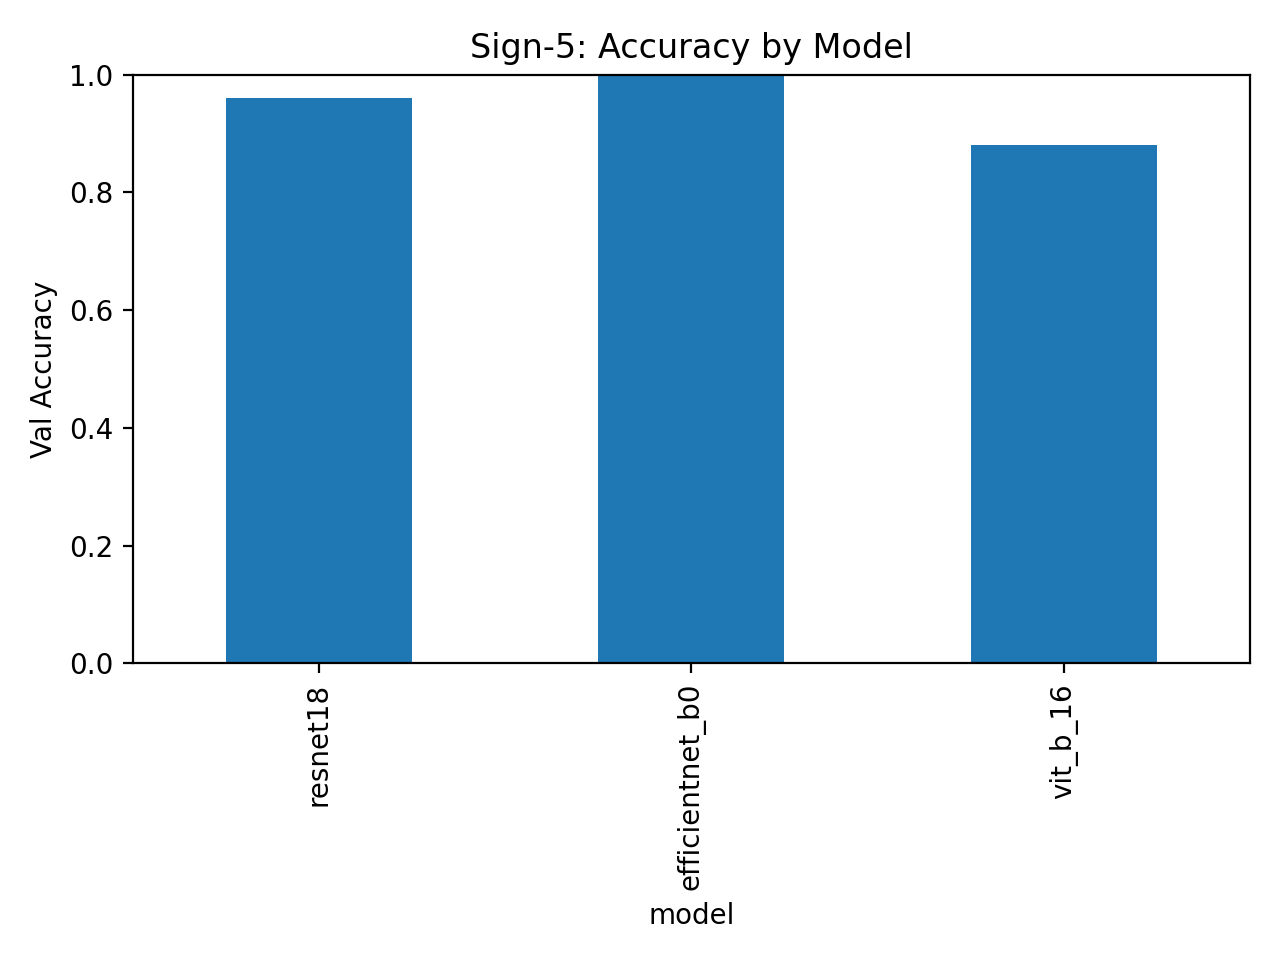

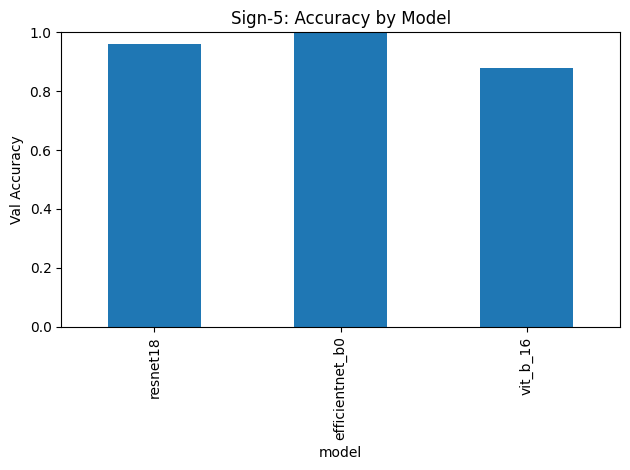

In [4]:
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, models

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def build(model_name, num_classes=NC, device=DEVICE):
    if model_name=="resnet18":
        m=models.resnet18(weights=models.ResNet18_Weights.DEFAULT); m.fc=nn.Linear(m.fc.in_features,num_classes)
        w=models.ResNet18_Weights.DEFAULT
    elif model_name=="efficientnet_b0":
        m=models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT); m.classifier[-1]=nn.Linear(m.classifier[-1].in_features,num_classes)
        w=models.EfficientNet_B0_Weights.DEFAULT
    elif model_name=="vit_b_16":
        m=models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT); m.heads.head=nn.Linear(m.heads.head.in_features,num_classes)
        w=models.ViT_B_16_Weights.DEFAULT
    else: raise ValueError("resnet18/efficientnet_b0/vit_b_16")
    return m.to(device), w

def loaders(train_root, val_root, weights, bs=32, workers=2):
    tfm = weights.transforms()
    tr_ds = datasets.ImageFolder(str(train_root), transform=tfm)
    va_ds = datasets.ImageFolder(str(val_root),   transform=tfm)
    return (DataLoader(tr_ds, bs, True,  num_workers=workers, pin_memory=True),
            DataLoader(va_ds, bs, False, num_workers=workers, pin_memory=True))

@torch.no_grad()
def eval_acc(model, dl):
    model.eval(); right=tot=0
    for x,y in dl:
        x,y=x.to(DEVICE), y.to(DEVICE)
        pred=model(x).argmax(1)
        right+=(pred==y).sum().item(); tot+=y.numel()
    return right/tot

from pathlib import Path
import pandas as pd, matplotlib.pyplot as plt
OUT = PROJ/"results"; OUT.mkdir(parents=True, exist_ok=True)

def train_one(name, epochs=8, bs=32, lr=1e-3):
    m,w = build(name, NC, DEVICE)
    tr,va = loaders(TRAIN_USE, VAL_USE, w, bs=bs)
    # freeze backbone speeds training
    for n,p in m.named_parameters():
        if not any(k in n for k in ["fc","classifier","heads"]): p.requires_grad=False
    opt = torch.optim.AdamW(filter(lambda p:p.requires_grad, m.parameters()), lr=lr, weight_decay=1e-4)
    loss = nn.CrossEntropyLoss()
    best=0.0
    for ep in range(1,epochs+1):
        m.train()
        for x,y in tr:
            x,y=x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad(); l=loss(m(x),y); l.backward(); opt.step()
        acc=eval_acc(m,va)
        print(f"[{name}] epoch {ep} val_acc={acc:.4f}")
        torch.save(m.state_dict(), OUT/f"{name}_last.pdf")
        if acc>best:
            best=acc; torch.save(m.state_dict(), OUT/f"{name}_best.pdf")
    return best

metrics=[]
for name in ["resnet18","efficientnet_b0","vit_b_16"]:
    metrics.append({"model": name, "val_acc": train_one(name, epochs=8, bs=32)})

pd.DataFrame(metrics).to_csv(OUT/"metrics.csv", index=False)
# Figure
df = pd.DataFrame(metrics)
ax = df.plot(x="model", y="val_acc", kind="bar", legend=False)
ax.set_ylim(0,1); ax.set_ylabel("Val Accuracy"); ax.set_title("Sign-5: Accuracy by Model")
ax.figure.tight_layout(); ax.figure.savefig(OUT/"figs/acc_by_model.png", dpi=200)
from IPython.display import Image, display; display(Image(filename=str(OUT/"figs/acc_by_model.png")))


In [7]:
def test_accuracy(name):
    m,_ = build(name, NC, DEVICE)
    m.load_state_dict(torch.load(OUT/f"{name}_best.pdf", map_location=DEVICE)); m.eval()
    _, w = build(name, NC, DEVICE)
    test_ds = datasets.ImageFolder(str(TEST_USE), transform=w.transforms())
    test_dl = DataLoader(test_ds, 32, False)
    return eval_acc(m, test_dl)

for name in ["resnet18","efficientnet_b0","vit_b_16"]:
    print(name, "test_acc:", f"{test_accuracy(name):.4f}")


resnet18 test_acc: 0.9231
efficientnet_b0 test_acc: 1.0000
vit_b_16 test_acc: 0.9231


In [16]:
import torch, time, numpy as np, pandas as pd, onnxruntime as ort

def export_ts(name):
    m,_ = build(name, NC, DEVICE)
    m.load_state_dict(torch.load(OUT/f"{name}_best.pdf", map_location=DEVICE)); m.eval()
    ts = torch.jit.trace(m, torch.randn(1,3,224,224, device=DEVICE))
    torch.jit.save(ts, OUT/f"{name}_ts.pt"); print("Saved TS:", OUT/f"{name}_ts.pt")

def export_onnx(name):
    m,_ = build(name, NC, DEVICE)
    m.load_state_dict(torch.load(OUT/f"{name}_best.pdf", map_location=DEVICE)); m.eval()
    dummy = torch.randn(1,3,224,224, device=DEVICE)
    torch.onnx.export(m, dummy, OUT/f"{name}.onnx",
                      input_names=["input"], output_names=["logits"],
                      dynamic_axes={"input":{0:"batch"}, "logits":{0:"batch"}},
                      opset_version=17)
    print("Saved ONNX:", OUT/f"{name}.onnx")

for n in ["resnet18","efficientnet_b0"]:
    export_ts(n); export_onnx(n)

def tavg(fn, iters=50, warmup=10):
    for _ in range(warmup): fn()
    t0=time.time()
    for _ in range(iters): fn()
    return (time.time()-t0)*1000/iters

def bench_pytorch(model, bs):
    x = torch.randn(bs,3,224,224, device=DEVICE)
    @torch.inference_mode()
    def step(): _ = model(x).argmax(1)
    return tavg(step)

def bench_ts(ts_path, bs):
    m = torch.jit.load(ts_path, map_location=DEVICE).eval()
    x = torch.randn(bs,3,224,224, device=DEVICE)
    @torch.inference_mode()
    def step(): _ = m(x).argmax(1)
    return tavg(step)

def bench_onnx(onnx_path, bs):
    providers = ["CUDAExecutionProvider","CPUExecutionProvider"] if torch.cuda.is_available() else ["CPUExecutionProvider"]
    sess = ort.InferenceSession(str(onnx_path), providers=providers)
    x = np.random.randn(bs,3,224,224).astype(np.float32)
    def step(): _ = sess.run(["logits"], {"input": x})
    return tavg(step)

rows=[]
for name in ["resnet18","efficientnet_b0"]:
    m,_ = build(name, NC, DEVICE)
    m.load_state_dict(torch.load(OUT/f"{name}_best.pdf", map_location=DEVICE)); m.eval()
    for bs in [1,32]:
        rows.append(dict(model=name, impl="pytorch",    bs=bs, ms=bench_pytorch(m, bs)))
        rows.append(dict(model=name, impl="torchscript", bs=bs, ms=bench_ts(OUT/f"{name}_ts.pt", bs)))
        rows.append(dict(model=name, impl="onnxruntime", bs=bs, ms=bench_onnx(OUT/f"{name}.onnx", bs)))

bench = pd.DataFrame(rows); bench["img_s"] = (1000/bench["ms"])*bench["bs"]
bench.to_csv(OUT/"bench.csv", index=False); bench

Saved TS: /content/sign_proj/results/resnet18_ts.pt


/tmp/ipython-input-3835086267.py:13: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(m, dummy, OUT/f"{name}.onnx",


Saved ONNX: /content/sign_proj/results/resnet18.onnx
Saved TS: /content/sign_proj/results/efficientnet_b0_ts.pt
Saved ONNX: /content/sign_proj/results/efficientnet_b0.onnx


/usr/local/lib/python3.12/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


,model,impl,bs,ms,img_s
0,resnet18,pytorch,1,3.199520,312.546871
1,resnet18,torchscript,1,1.834874,544.996505
2,resnet18,onnxruntime,1,30.973625,32.285533
3,resnet18,pytorch,32,28.286920,1131.264926
4,resnet18,torchscript,32,27.718930,1154.445706
5,resnet18,onnxruntime,32,1198.595457,26.697915
6,efficientnet_b0,pytorch,1,7.601056,131.560666
7,efficientnet_b0,torchscript,1,3.923011,254.906256
8,efficientnet_b0,onnxruntime,1,22.963085,43.548155
9,efficientnet_b0,pytorch,32,37.555485,852.072612


In [15]:
!pip install onnx -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 113.7 MB/s eta 0:00:00


In [9]:
!pip install onnxruntime -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.0 MB/s eta 0:00:00


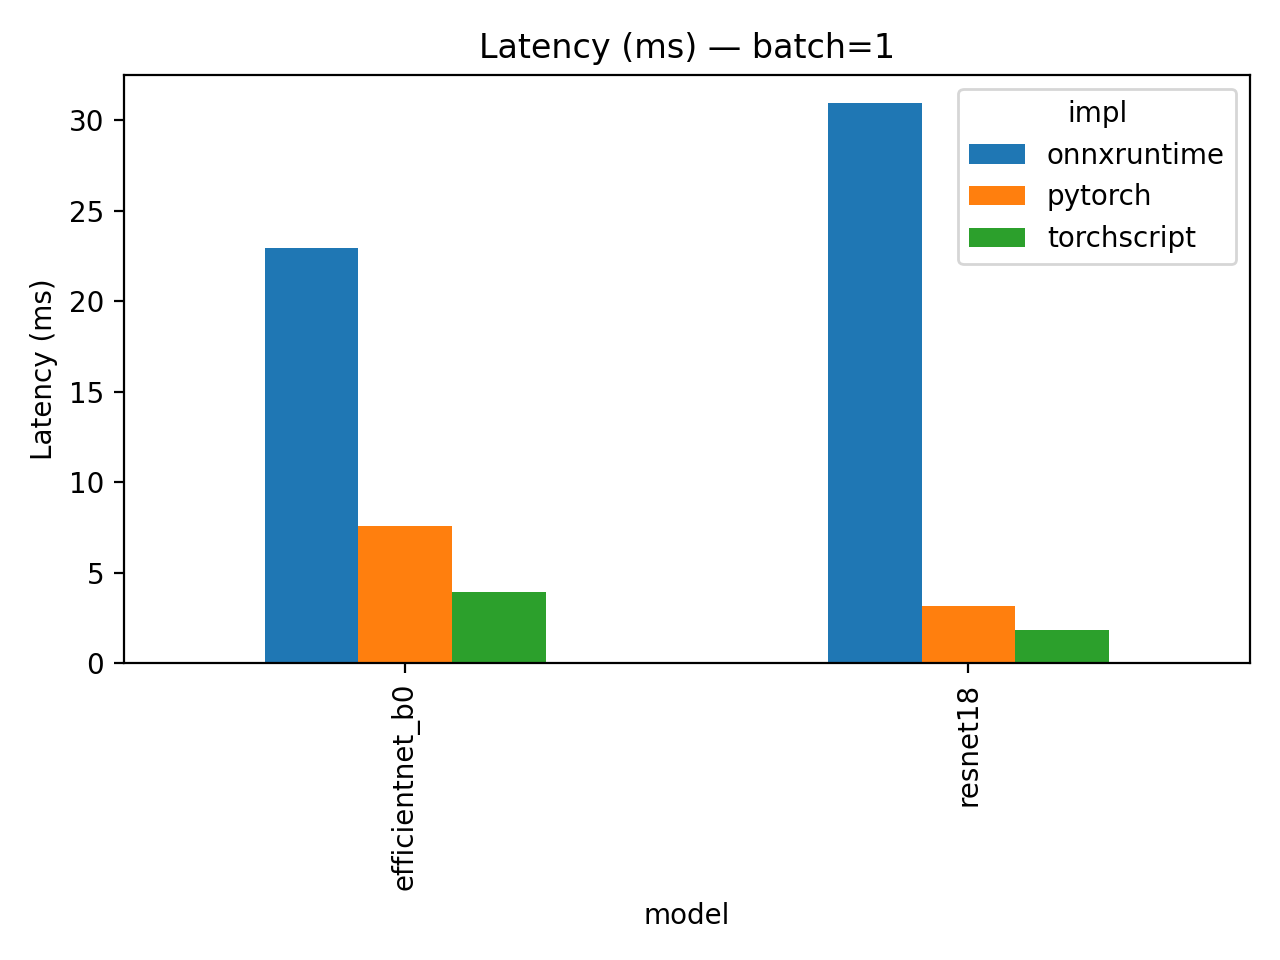

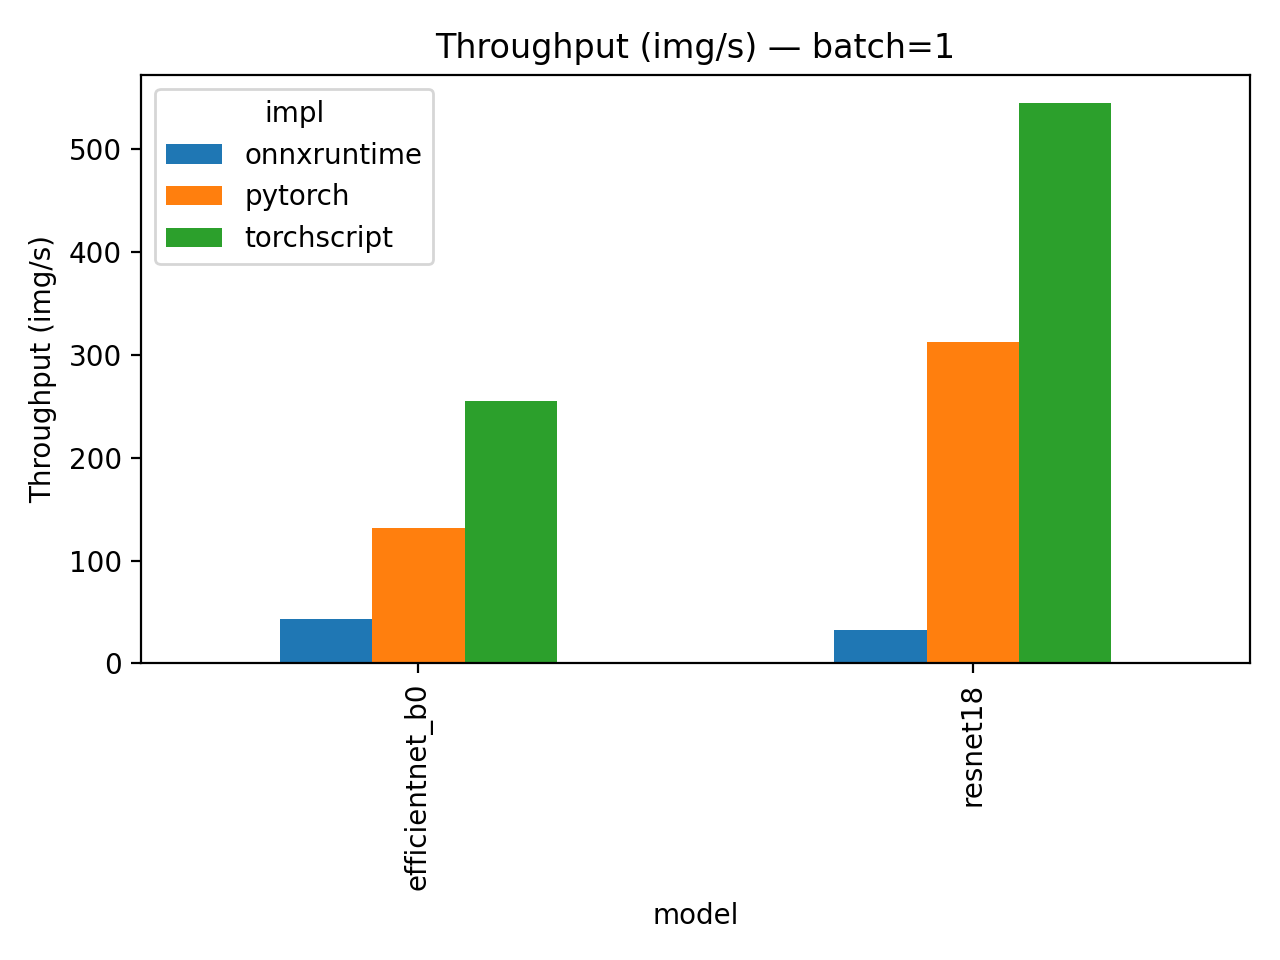

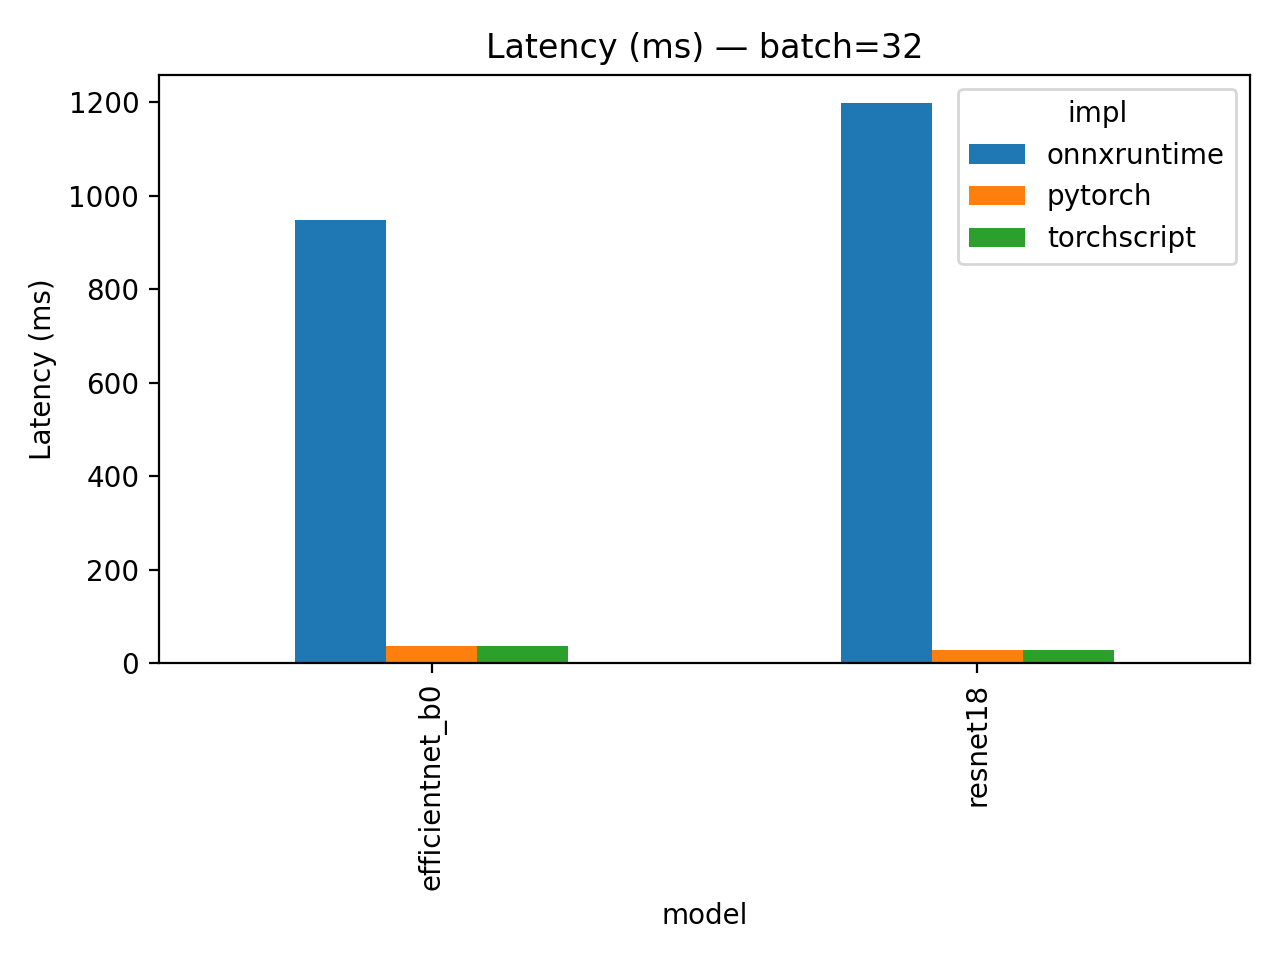

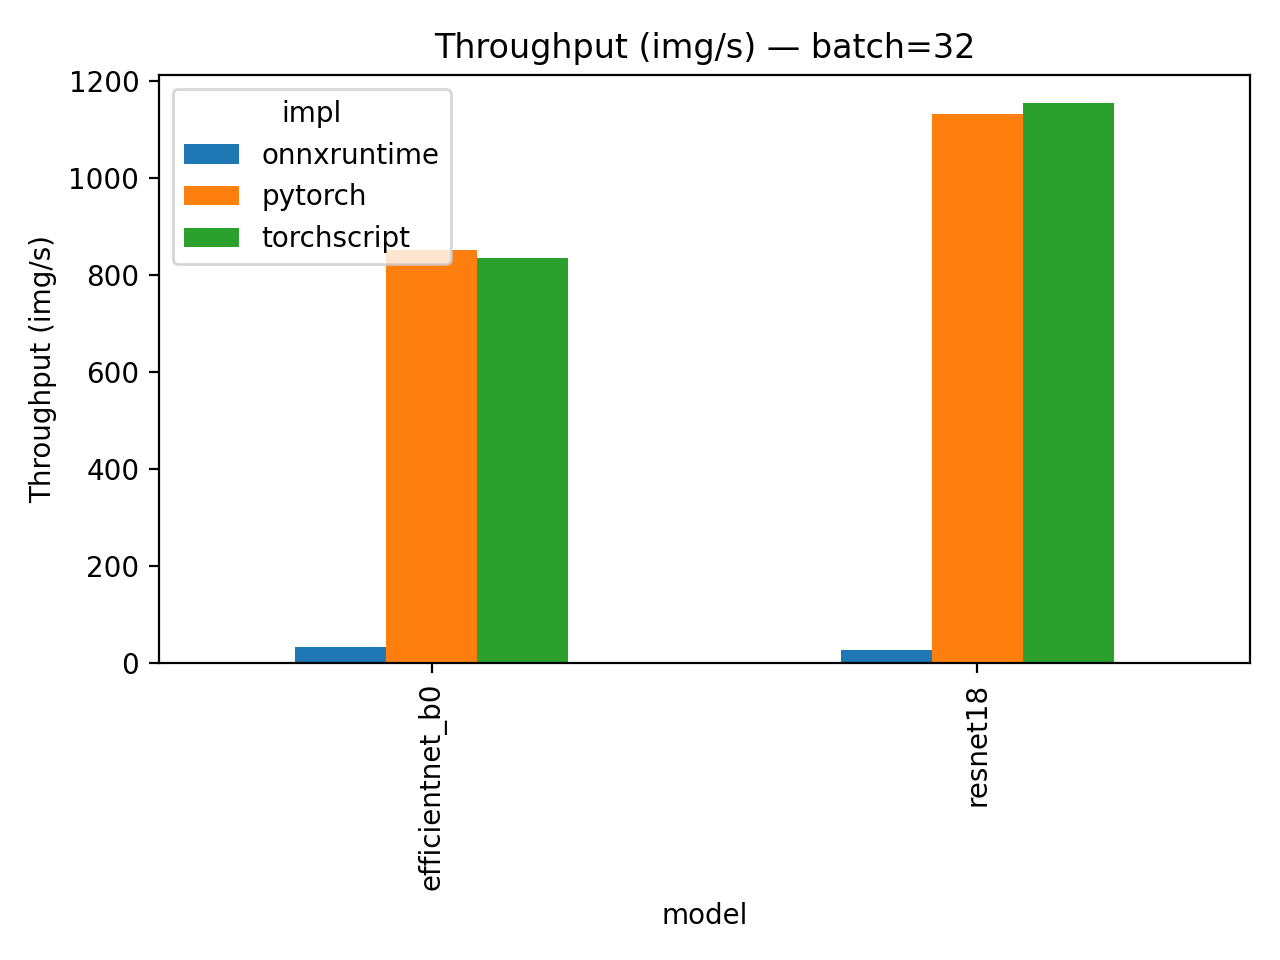

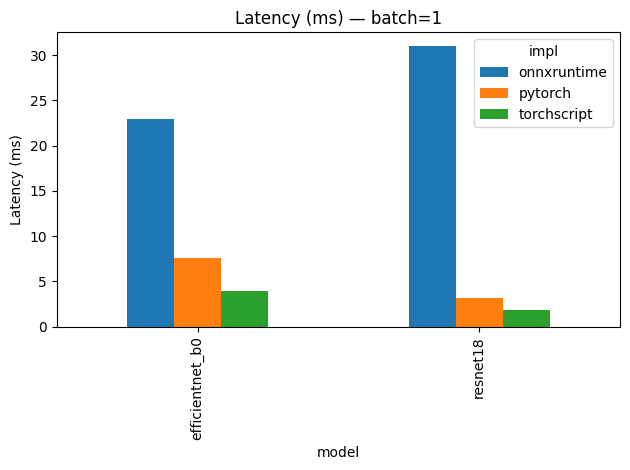

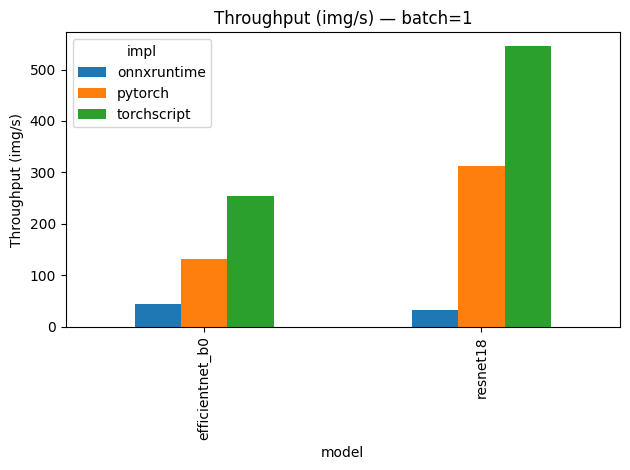

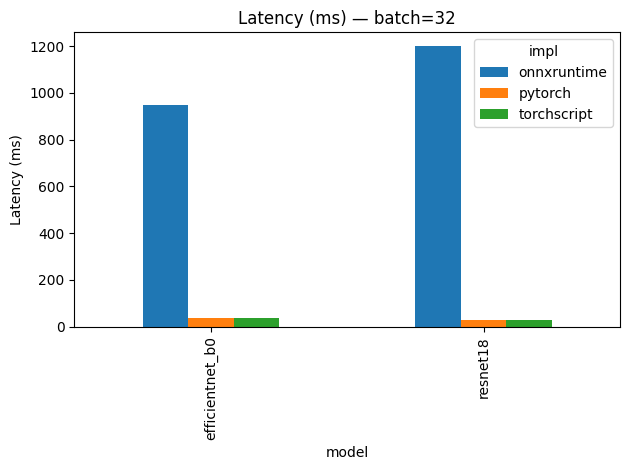

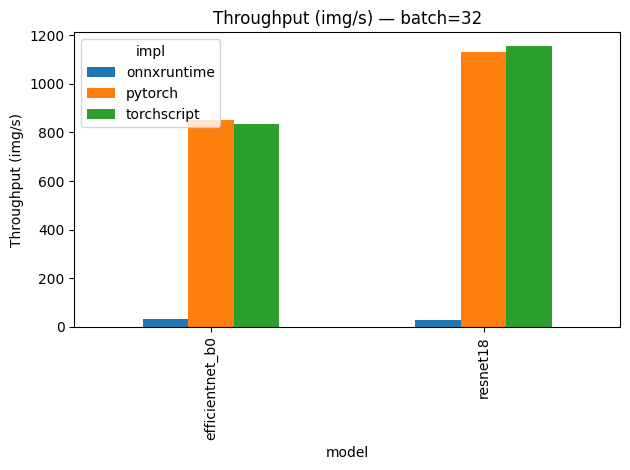

In [17]:
import pandas as pd, matplotlib.pyplot as plt
bench = pd.read_csv(OUT/"bench.csv")
for bs in [1,32]:
    sub = bench[bench.bs==bs]
    for col,title in [("ms","Latency (ms)"), ("img_s","Throughput (img/s)")]:
        ax = sub.pivot(index="model", columns="impl", values=col).plot(kind="bar")
        ax.set_ylabel(title); ax.set_title(f"{title} — batch={bs}")
        ax.figure.tight_layout(); ax.figure.savefig(OUT/f"figs/{col}_bs{bs}.png", dpi=200)

from IPython.display import Image, display
display(Image(filename=str(OUT/"figs/ms_bs1.png")))
display(Image(filename=str(OUT/"figs/img_s_bs1.png")))
display(Image(filename=str(OUT/"figs/ms_bs32.png")))
display(Image(filename=str(OUT/"figs/img_s_bs32.png")))


In [18]:
# Print the ONNX Runtime providers the session is using (document in your report)
import onnxruntime as ort, torch
from pathlib import Path
name = "resnet18"
onnx_path = PROJ/"results"/f"{name}.onnx"
sess = ort.InferenceSession(str(onnx_path), providers=["CUDAExecutionProvider","CPUExecutionProvider"])
print("Available providers:", ort.get_available_providers())
print("Session providers:", sess.get_providers())
print("Using GPU EP?" , "CUDAExecutionProvider" in sess.get_providers() and torch.cuda.is_available())


Available providers: ['AzureExecutionProvider', 'CPUExecutionProvider']
Session providers: ['CPUExecutionProvider']
Using GPU EP? False


/usr/local/lib/python3.12/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [19]:
# Reproducibility across Python/NumPy/Torch (CPU+CUDA)
import os, random, numpy as np, torch
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
# (optional) strict determinism; may slow down a bit:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print("Seeds set:", SEED, "| CUDA:", torch.cuda.is_available())


Seeds set: 1337 | CUDA: True


In [20]:
# Verify ImageFolder class-index order and counts per split
from torchvision import datasets
from pathlib import Path
import pandas as pd

# Try to pick existing dirs from previous cells
try:
    # Use the variables set in the data preparation and augmentation steps
    splits = {
        "train": Path(TRAIN_USE),
        "val":   Path(VAL_USE),
        "test":  Path(TEST_USE),
    }
except NameError:
    # Fallback if the variables are not defined
    DATA_BASE = Path("/content/sign_proj/data")
    splits = {
        "train": (DATA_BASE/"train"),
        "val":   (DATA_BASE/"val"),
        "test":  (DATA_BASE/"test"),
    }


def count_by_class(root: Path):
    rows=[]
    for cdir in sorted([d for d in root.iterdir() if d.is_dir()]):
        n = len([p for p in cdir.rglob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}])
        rows.append({"class": cdir.name, "count": n})
    return pd.DataFrame(rows)

# Show class_to_idx for train
train_ds = datasets.ImageFolder(str(splits["train"]))
print("ImageFolder class_to_idx:", train_ds.class_to_idx)
try:
    print("Declared names:", NAMES)
except NameError:
    NAMES = sorted(list(train_ds.class_to_idx.keys()))
    print("Declared names not found; using discovered:", NAMES)

for sp, path in splits.items():
    dfc = count_by_class(path)
    print(f"\n[{sp}] total={dfc['count'].sum()}")
    display(dfc)

ImageFolder class_to_idx: {'hello': 0, 'iloveyou': 1, 'no': 2, 'thankyou': 3, 'yes': 4}
Declared names: ['yes', 'no', 'hello', 'iloveyou', 'thankyou']

[train] total=500


,class,count
0,hello,100
1,iloveyou,100
2,no,100
3,thankyou,100
4,yes,100



[val] total=25


,class,count
0,hello,5
1,iloveyou,4
2,no,5
3,thankyou,6
4,yes,5



[test] total=13


,class,count
0,hello,2
1,iloveyou,5
2,no,1
3,thankyou,2
4,yes,3


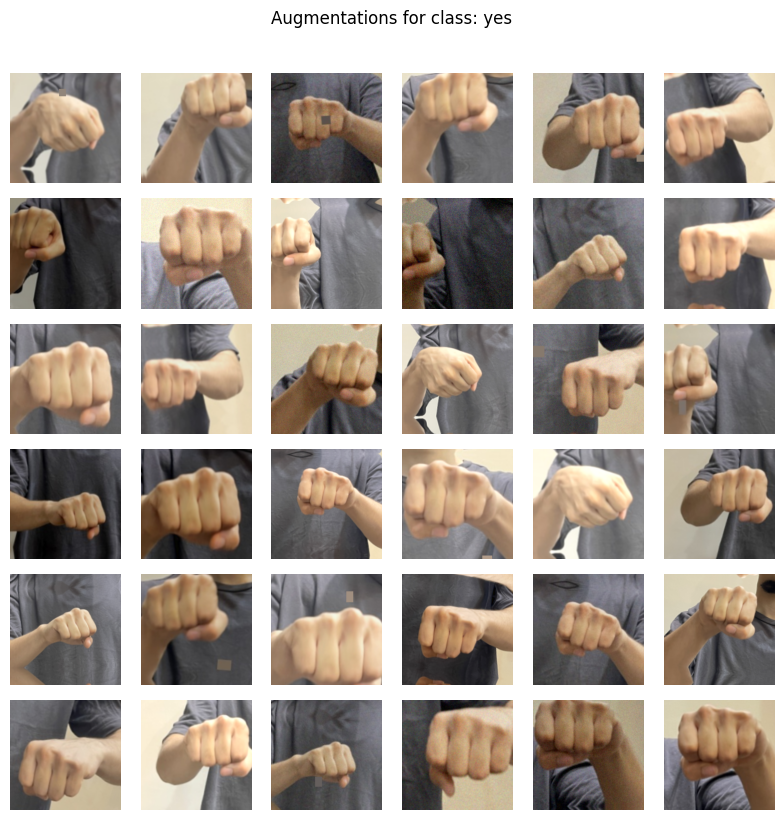

Saved preview grid to: /content/sign_proj/results/figs/augment_grid.svg


In [21]:
# ---- Robust augmentation preview grid (works with PIL or OpenCV augmenters) ----
import os, random, pathlib, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# Try to resolve paths/vars from your notebook
PROJ = Path(globals().get("PROJ", "/content/sign_proj"))
( PROJ/"results/figs" ).mkdir(parents=True, exist_ok=True)

OUT_IMG = Path(globals().get("OUT_IMG", PROJ/"data"))
TRAIN_USE = Path(globals().get("TRAIN_USE", OUT_IMG/"train"))

# Pick an existing class with images
def list_images(d):
    return [p for p in Path(d).glob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}]

class_dirs = [d for d in sorted(TRAIN_USE.iterdir()) if d.is_dir() and list_images(d)]
assert class_dirs, f"No images found under {TRAIN_USE}"
sample_dir = random.choice(class_dirs)
sample_class = sample_dir.name
images = list_images(sample_dir)
assert images, f"No images found in {sample_dir}"

# Decide which augmenter is available
use_cv2 = "augment_once_bgr" in globals()
use_pil = "augment_once" in globals() and not use_cv2

# Define mild fallback augmenters if neither is available
if not use_cv2 and not use_pil:
    # Fallback PIL augmenter (gentle)
    from PIL import Image, ImageOps, ImageEnhance, ImageFilter
    import math
    def augment_once(im):
        im = im.convert("RGB")
        # resize longest side to 256, reflect-pad to square, center-crop 224
        w,h = im.size
        s = max(w,h)
        scale = 256/s
        im = im.resize((int(w*scale), int(h*scale)), Image.BICUBIC)
        im = ImageOps.pad(im, (256,256), method=Image.BICUBIC, color=None, centering=(0.5,0.5))
        # gentle rotate/shift
        im = im.rotate(random.uniform(-8,8), resample=Image.BICUBIC, expand=False, fillcolor=None)
        # light jitter
        if random.random()<0.7: im = ImageEnhance.Brightness(im).enhance(1+random.uniform(-0.08,0.08))
        if random.random()<0.7: im = ImageEnhance.Contrast(im).enhance(1+random.uniform(-0.08,0.08))
        if random.random()<0.1: im = im.filter(ImageFilter.GaussianBlur(radius=0.7))
        # center crop 224
        im = ImageOps.fit(im, (224,224), method=Image.BICUBIC, centering=(0.5,0.5))
        return im
    use_pil = True

# Build grid
k = min(36, len(images))
sel = random.sample(images, k)

fig, axes = plt.subplots(6, 6, figsize=(8,8))
i = 0
for ax in axes.flat:
    if i < k:
        p = sel[i]
        if use_cv2:
            # OpenCV augmenter path
            import cv2
            img_bgr = cv2.imread(str(p))
            if img_bgr is None:
                ax.axis('off'); i += 1; continue
            aug_bgr = augment_once_bgr(img_bgr)     # uses your defined function
            aug_rgb = cv2.cvtColor(aug_bgr, cv2.COLOR_BGR2RGB)
            ax.imshow(aug_rgb)
        else:
            # PIL augmenter path
            from PIL import Image
            with Image.open(p) as im:
                aug = augment_once(im)              # uses your defined function or fallback
            ax.imshow(aug)
        ax.axis('off')
        i += 1
    else:
        ax.axis('off')

plt.suptitle(f"Augmentations for class: {sample_class}", y=1.02)
plt.tight_layout()
save_path = PROJ/"results/figs/augment_grid.svg"
fig.savefig(save_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved preview grid to:", save_path)


Macro-F1: 0.8667
Saved: /content/sign_proj/results/figs/confusion_matrix_test.svg


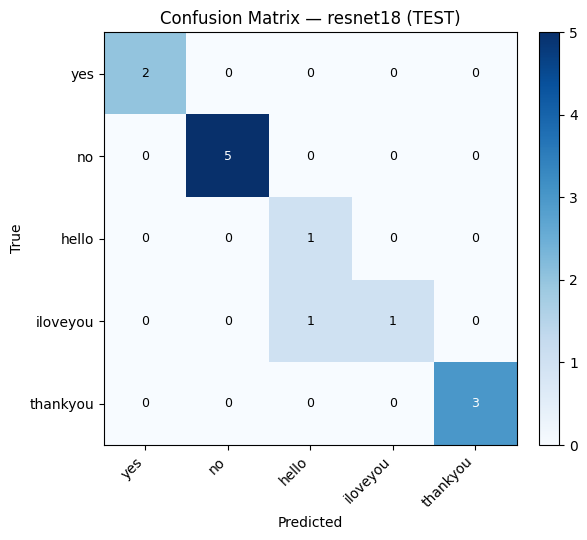

In [24]:
import torch, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

PROJ = Path(globals().get("PROJ","/content/sign_proj"))
( PROJ/"results/figs" ).mkdir(parents=True, exist_ok=True)
DEVICE = globals().get("DEVICE","cuda" if torch.cuda.is_available() else "cpu")
MODEL_FOR_REPORT = globals().get("MODEL_FOR_REPORT","resnet18")
build_fn = globals().get("build")
assert callable(build_fn)

# Resolve names/classes
try:
    NAMES = list(globals()["NAMES"])
except KeyError:
    TEST_USE = Path(globals().get("TEST_USE", PROJ/"data/test"))
    NAMES = datasets.ImageFolder(str(TEST_USE)).classes
NC = len(NAMES)

# Build model & transforms
m, w = build_fn(MODEL_FOR_REPORT, NC, DEVICE)
ckpt = PROJ/"results"/f"{MODEL_FOR_REPORT}_best.pdf"
m.load_state_dict(torch.load(ckpt, map_location=DEVICE)); m.eval()

tfm = w.transforms() if hasattr(w,"transforms") else transforms.Compose([
    transforms.Resize((224,224)), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

TEST_USE = Path(globals().get("TEST_USE", PROJ/"data/test"))
test_ds = datasets.ImageFolder(str(TEST_USE), transform=tfm)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

# Collect preds/labels
all_y, all_p = [], []
with torch.inference_mode():
    for x,y in test_dl:
        x = x.to(DEVICE)
        p = m(x).argmax(1).cpu()
        all_p.append(p); all_y.append(y)
y_true = torch.cat(all_y)
y_pred = torch.cat(all_p)

# Confusion matrix (PyTorch)
cm = torch.zeros(NC, NC, dtype=torch.int64)
for t,p in zip(y_true, y_pred):
    cm[t, p] += 1

# Macro-F1 (PyTorch)
tp = cm.diag().to(torch.float32)
fp = cm.sum(0).to(torch.float32) - tp
fn = cm.sum(1).to(torch.float32) - tp
precision = tp / torch.clamp(tp + fp, min=1)
recall    = tp / torch.clamp(tp + fn, min=1)
f1_per_class = 2 * precision * recall / torch.clamp(precision + recall, min=1e-12)
macro_f1 = f1_per_class.mean().item()
print(f"Macro-F1: {macro_f1:.4f}")

# Plot and save
fig, ax = plt.subplots(figsize=(6.5,5.5))
im = ax.imshow(cm.numpy(), cmap="Blues")
ax.set_title(f"Confusion Matrix — {MODEL_FOR_REPORT} (TEST)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(NC)); ax.set_xticklabels(NAMES, rotation=45, ha='right')
ax.set_yticks(range(NC)); ax.set_yticklabels(NAMES)
th = cm.max().item()/2 if cm.numel() else 0
for i in range(NC):
    for j in range(NC):
        val = int(cm[i,j])
        ax.text(j, i, val, ha="center", va="center",
                color=("white" if val>th else "black"), fontsize=9)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()
save_png = PROJ/"results/figs/confusion_matrix_test.svg"
fig.savefig(save_png, dpi=200, bbox_inches="tight")
print("Saved:", save_png)


In [25]:
# Install if needed
!pip -q install open-clip-torch --upgrade

import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import open_clip, time

# Check for CUDA availability and set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BACKBONE = "ViT-B-32"
PRETRAIN = "laion2b_s34b_b79k"
BATCH = 32
EPOCHS = 5
LR = 1e-3

# Data: use ImageFolder train/val we built
# Use the variables set in the data preparation and augmentation steps
try:
    train_dir = Path(TRAIN_USE)
    val_dir = Path(VAL_USE)
except NameError:
    # Fallback if the variables are not defined (shouldn't happen if previous cells ran)
    DATA_BASE = Path("/content/sign_proj/data")
    train_dir = DATA_BASE/"train"
    val_dir = DATA_BASE/"val"


model, _, preprocess = open_clip.create_model_and_transforms(BACKBONE, pretrained=PRETRAIN, device=DEVICE)
for p in model.parameters(): p.requires_grad=False  # freeze
feat_dim = model.visual.output_dim
head = nn.Linear(feat_dim, len(NAMES)).to(DEVICE)

train_ds = datasets.ImageFolder(str(train_dir), transform=preprocess)
val_ds   = datasets.ImageFolder(str(val_dir),   transform=preprocess)
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

opt = torch.optim.AdamW(head.parameters(), lr=LR)
crit = nn.CrossEntropyLoss()

@torch.no_grad()
def acc(dl):
    right=tot=0
    for x,y in dl:
        x,y = x.to(DEVICE), y.to(DEVICE)
        feats = model.encode_image(x)
        logits = head(feats)
        right += (logits.argmax(1)==y).sum().item(); tot += y.numel()
    return right/tot

best=0.0
for ep in range(1, EPOCHS+1):
    head.train()
    for x,y in train_dl:
        x,y = x.to(DEVICE), y.to(DEVICE)
        with torch.no_grad():
            feats = model.encode_image(x)
        loss = crit(head(feats), y)
        opt.zero_grad(); loss.backward(); opt.step()
    va = acc(val_dl)
    print(f"[CLIP linear] epoch {ep} val_acc={va:.4f}")
    if va>best:
        best=va; torch.save(head.state_dict(), PROJ/"results"/"clip_linear_best.pth")
print("Best CLIP-linear val_acc:", best)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

[CLIP linear] epoch 1 val_acc=0.7600
[CLIP linear] epoch 2 val_acc=0.9200
[CLIP linear] epoch 3 val_acc=0.8800
[CLIP linear] epoch 4 val_acc=0.9200
[CLIP linear] epoch 5 val_acc=0.9200
Best CLIP-linear val_acc: 0.92
